In [ ]:
First, we import the basic modules and tweak figure display parameters

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import display, HTML

#set precision for displaying float-point values in the notebook
pd.options.display.float_format = '{:,.3f}'.format

#set figure dpi to 100 to get reasonably sized figures displayed in the notebook
plt.rc('figure', dpi=100)

#set savefig dpi to 300 to get high-quality images to insert in the paper
plt.rc('savefig', dpi=300)

#set to 'pdf' or 'eps' for vector figures or to 'png'
plt.rc('savefig', format='png')

#set font sizes for figures throughout
plt.rc('xtick', labelsize=18)
plt.rc('ytick', labelsize=18)
plt.rc('axes', labelsize=20)
plt.rc('legend', fontsize=18)

#choose data input: Experiment 1 or Experiment 2
exp = 'HEM_exp_1'

Then, we read the data (assuming it's already pre-processed). Change the path to the files if necessary

In [2]:
import data_reader
dr = data_reader.DataReader()
choices, dynamics = dr.get_data(path='../../data/%s/processed/' % (exp))
subjects = choices.subj_id.unique()

# if Exp1 and Exp2 data need to be plotted alongside each other, read those data into separate dataframes
#choices_1, dynamics_1 = dr.get_data(path='../../data/%s/processed/' % ('HEM_exp_1'))
#choices_2, dynamics_2 = dr.get_data(path='../../data/%s/processed/' % ('HEM_exp_2'))

To start with, look at probability of change-of-mind for each individual participant

In [3]:
display(HTML(choices.groupby(level='subj_id').is_com.mean().rename('p_com').to_frame().to_html(formatters={'p_com': '{:,.1%}'.format})))

# ax = sns.barplot(subjects, choices.groupby(level='subj_id').is_com.mean(), order=subjects, palette='muted')
# ax.set_xlabel('Participant')
# ax.set_ylabel('P(CoM)')
# plt.savefig('figures/p_com_vs_participant_%s' % (exp))

,p_com
subj_id,
269,4.4%
275,0.6%
391,7.8%
451,1.4%


Plot probability and number of changes-of-mind per participant per coherence level

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: 'subj_id' is both a column name and an index level.
Defaulting to column but this will raise an ambiguity error in a future version
  """Entry point for launching an IPython kernel.


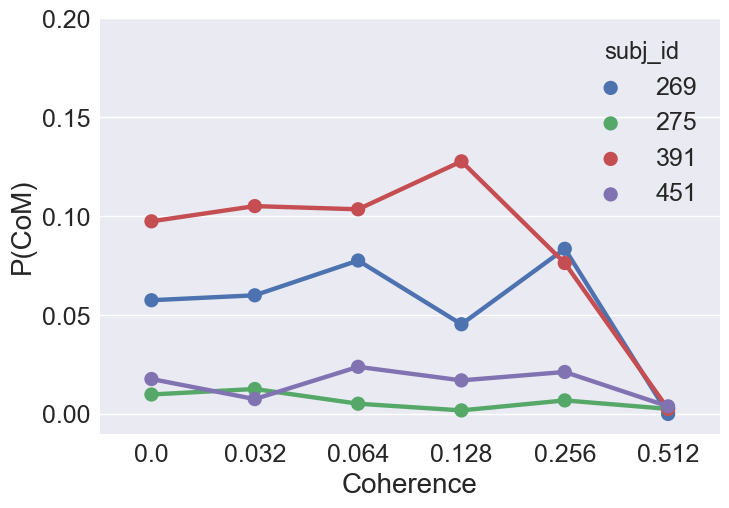

In [4]:
p_com = choices.groupby(by=['is_correct', 'subj_id', 'coherence']).apply(lambda c: len(c[c.is_com])/len(c)).rename('p_com')
ax = sns.pointplot(data=p_com.reset_index(), x='coherence', y='p_com', hue='subj_id', ci=None)
ax.set_xlabel('Coherence')
ax.set_ylabel('P(CoM)')
ax.set_ylim([-0.01, 0.2]);

plt.savefig('figures/p_com_vs_coherence_%s' % (exp))

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: 'subj_id' is both a column name and an index level.
Defaulting to column but this will raise an ambiguity error in a future version
  """Entry point for launching an IPython kernel.


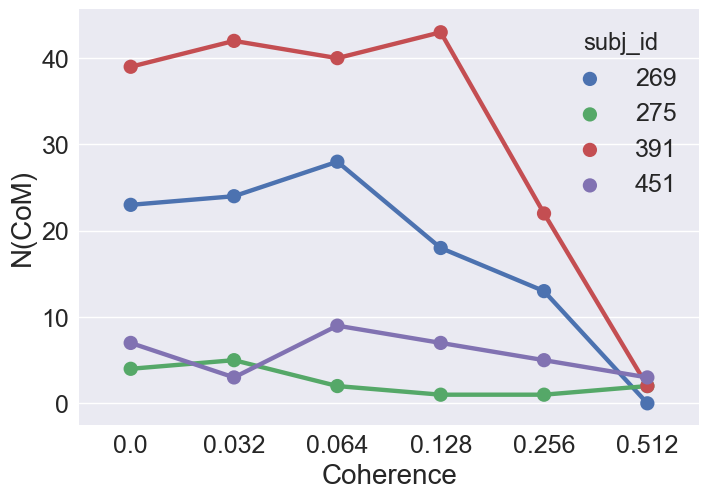

In [5]:
com_count = choices.groupby(by=['subj_id', 'coherence']).apply(lambda c: len(c[c.is_com])).rename('com_count')
ax = sns.pointplot(data=com_count.reset_index(), x='coherence', y='com_count', hue='subj_id', ci=None)
ax.set_xlabel('Coherence')
ax.set_ylabel('N(CoM)')
plt.savefig('figures/n_com_vs_coherence_%s' % (exp))

Plot individual psychometric functions separately for CoM and no-Com trials

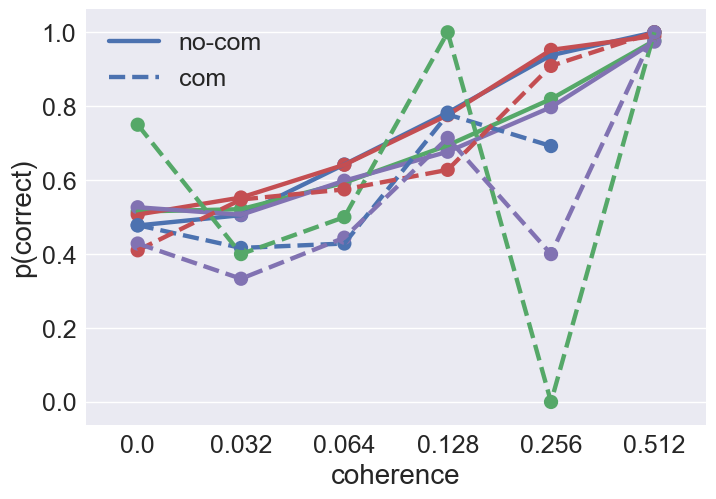

In [6]:
def plot_psychometric_function_individual(c, color):
    psf = [len(c[(c.is_correct) & (c.subj_id==subj_id) & (c.coherence==coherence) & (c.is_com==is_com)]) / 
                   len(c[(c.subj_id==subj_id) & (c.coherence==coherence) & (c.is_com==is_com)]) 
               if len(c[(c.subj_id==subj_id) & (c.coherence==coherence) & (c.is_com==is_com)]) else np.NaN 
           for subj_id in np.sort(c.subj_id.unique()) 
           for coherence in np.sort(c.coherence.unique()) 
           for is_com in np.sort(c.is_com.unique())]
    
    p_correct = pd.DataFrame(psf, columns=['p_correct'], 
                        index=pd.MultiIndex.from_product([np.sort(c.subj_id.unique()), 
                                                          np.sort(c.coherence.unique()), 
                                                          np.sort(c.is_com.unique())], 
                                                         names=['subj_id', 'coherence', 'is_com']))
    
    ax = sns.pointplot(data=p_correct.reset_index(), x='coherence', y='p_correct', hue='is_com',
                       palette=[color, color], linestyles=['-', '--'], errwidth=1.0, capsize=.1)
    
    ax.set_xlabel('coherence')
    ax.set_ylabel('p(correct)')
    ax.legend(handles=ax.lines[::3*len(choices.coherence.unique())+1], labels=['no-com','com'])
    
    return ax

def plot_psychometric_functions(choices):
    colors = ['C0', 'C1', 'C2', 'C3']
    for i, subj_id in enumerate(choices.subj_id.unique()):
        ax = plot_psychometric_function_individual(choices.loc[subj_id], color=colors[i])

plot_psychometric_functions(choices)
plt.savefig('figures/psychometric_function_individual_%s' % (exp))

Note that as Participant 275 (green lines) has very few CoMs, their psychometric function is very noisy, especially at higher coherence levels. For this reason, we probably won't be able to fit the model to this individual, and also maybe Participant 451. If we don't do individual fits though, we can just fit to psychometric function calculated for all participant within an experiment. This is how it looks like

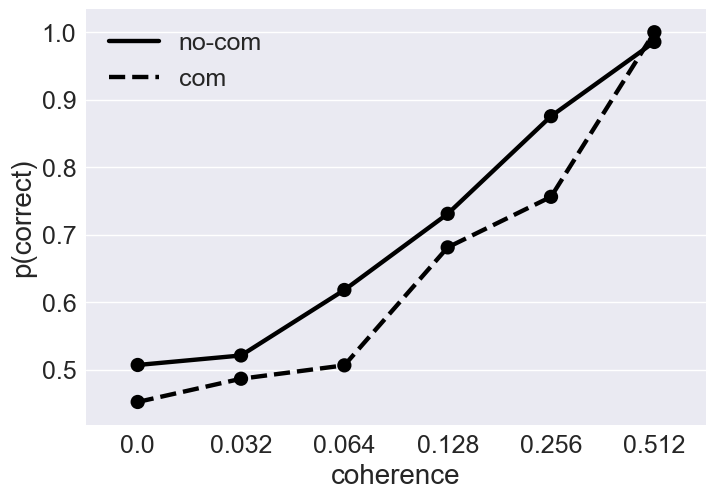

In [7]:
def plot_psychometric_function_aggregate(c, color='k'):
    psf = [len(c[(c.is_correct) & (c.coherence==coherence) & (c.is_com==is_com)]) / 
                   len(c[(c.coherence==coherence) & (c.is_com==is_com)]) 
               if len(c[(c.coherence==coherence) & (c.is_com==is_com)]) else np.NaN  
           for coherence in np.sort(c.coherence.unique()) 
           for is_com in np.sort(c.is_com.unique())]
    
    p_correct = pd.DataFrame(psf, columns=['p_correct'], 
                        index=pd.MultiIndex.from_product([np.sort(c.coherence.unique()), 
                                                          np.sort(c.is_com.unique())], 
                                                         names=['coherence', 'is_com']))
    ax = sns.pointplot(data=p_correct.reset_index(), x='coherence', y='p_correct', hue='is_com',
                       palette=[color, color], linestyles=['-', '--'])
    
    ax.set_xlabel('coherence')
    ax.set_ylabel('p(correct)')
    ax.legend(handles=ax.lines[::len(choices.coherence.unique())+1], labels=['no-com','com'])
    
    return ax

plot_psychometric_function_aggregate(choices)
plt.savefig('figures/psychometric_function_%s' % (exp))

    coherence  is_com  p_correct  ci_l  ci_r
0       0.000   False      0.507 0.494 0.520
1       0.000    True      0.452 0.394 0.510
2       0.032   False      0.521 0.508 0.534
3       0.032    True      0.486 0.428 0.545
4       0.064   False      0.618 0.606 0.630
5       0.064    True      0.506 0.450 0.563
6       0.128   False      0.731 0.720 0.742
7       0.128    True      0.681 0.625 0.737
8       0.256   False      0.876 0.867 0.884
9       0.256    True      0.756 0.689 0.823
10      0.512   False      0.986 0.983 0.989
11      0.512    True      1.000 1.000 1.000


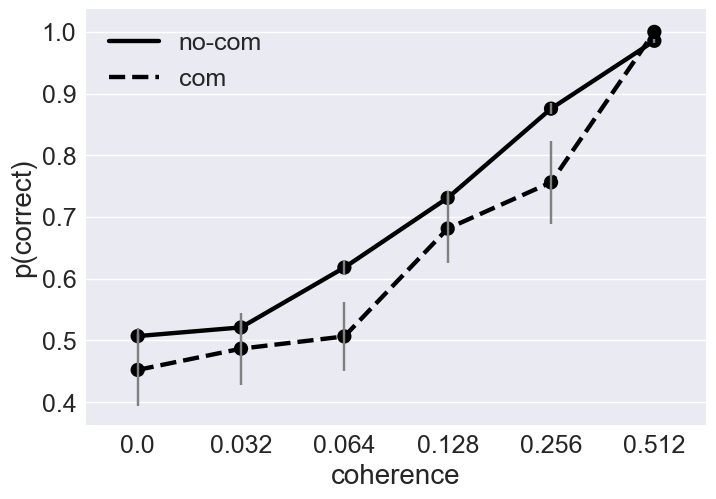

In [8]:
from statsmodels.stats.proportion import proportion_confint

def get_ci(c):
    psf = np.array([len(c[(c.is_correct) & (c.coherence==coherence) & (c.is_com==is_com)]) / 
                   len(c[(c.coherence==coherence) & (c.is_com==is_com)]) 
               if len(c[(c.coherence==coherence) & (c.is_com==is_com)]) else np.NaN  
           for coherence in np.sort(c.coherence.unique()) 
           for is_com in np.sort(c.is_com.unique())])
    n = [len(c[(c.coherence==coherence) & (c.is_com==is_com)]) 
                      for coherence in np.sort(c.coherence.unique()) 
                      for is_com in np.sort(c.is_com.unique())]
#     n_correct = [len(c[(c.is_correct) & (c.coherence==coherence) & (c.is_com==is_com)])
#                        for coherence in np.sort(c.coherence.unique()) 
#                        for is_com in np.sort(c.is_com.unique())]
    
#     ci = pd.DataFrame(n, columns=['n'], index=pd.MultiIndex.from_product([np.sort(c.coherence.unique()), 
#                                                           np.sort(c.is_com.unique())], 
#                                                          names=['coherence', 'is_com']))
#     ci['n_correct'] = n_correct
    
#     ci['ci_l'], ci['ci_r'] = proportion_confint(count=np.array(n_correct), nobs=np.array(n), )
    ci = pd.DataFrame(psf, columns=['p_correct'], 
                        index=pd.MultiIndex.from_product([np.sort(c.coherence.unique()), 
                                                          np.sort(c.is_com.unique())], 
                                                         names=['coherence', 'is_com']))
    ci['ci_l'] = ci['p_correct'] - np.sqrt(psf*(1-np.array(psf))/n)
    ci['ci_r'] = ci['p_correct'] + np.sqrt(psf*(1-psf)/n)
    
    return ci.reset_index()

ax = plot_psychometric_function_aggregate(choices)
ci = get_ci(choices)
print(ci)
ax.vlines(x=[val for pair in zip(range(0,6), range(0,6)) for val in pair], ymin=ci.ci_l, ymax=ci.ci_r, color='grey', zorder=10)